In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import glob
import os
import csv

def load_tensile_csv(csv_path):
    """
    Loads tensile raw data CSVs that may contain:
      - metadata header lines
      - mixed delimiters
      - inconsistent column counts
    Returns a cleaned DataFrame with numeric columns only.
    """

    # First: Detect delimiter
    with open(csv_path, "r") as f:
        sample = f.read(2048)

    try:
        sniffer = csv.Sniffer()
        dialect = sniffer.sniff(sample, delimiters=[',',';','\t',' '])
        delimiter = dialect.delimiter
    except:
        delimiter = ','  # fallback

    # Second: Read the file while skipping bad rows
    df = pd.read_csv(
        csv_path,
        sep=delimiter,
        engine="python",
        comment='#',
        skiprows=5,
        #on_bad_lines='skip',    # <-- prevents crash
        skip_blank_lines=True
    )

    # Third: Drop EMPTY or non-numeric columns
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except:
            df[col] = pd.NA

    df = df.dropna(axis=1, how='all')  # remove columns with no data
    df = df.dropna(axis=0, how='any')  # remove unfinished rows

    return df

def compute_youngs_modulus(
    csv_path,
    gauge_length,
    cross_section_area,
    load_col='Load',
    disp_col='Extension',
    elastic_strain_max=0.005
):
    """
    Computes Young's modulus from tensile test data.

    Parameters
    ----------
    csv_path : str
        Path to CSV file containing load/displacement data.
    gauge_length : float
        Original specimen length (m).
    cross_section_area : float
        Cross-sectional area (m^2).
    load_col : str
        Column name for load/force.
    disp_col : str
        Column name for displacement/extension.
    elastic_strain_max : float
        Maximum strain to use for the linear elastic fit (default = 0.5%).

    Returns
    -------
    E : float
        Estimated Young’s modulus (Pa).
    stress : ndarray
    strain : ndarray
        Arrays of engineering stress and strain.
    """

    # Load file
    df = load_tensile_csv(csv_path)

    # Extract data
    force = df[load_col].values
    disp  = df[disp_col].values

    # Engineering strain
    strain = disp / gauge_length

    # Engineering stress
    stress = force / cross_section_area

    # Select elastic region
    mask = strain <= elastic_strain_max
    strain_elastic = strain[mask].reshape(-1, 1)
    stress_elastic = stress[mask]

    # Linear regression (slope = E)
    model = LinearRegression().fit(strain_elastic, stress_elastic)
    E = model.coef_[0]

    return E, stress, strain, disp, force


In [35]:
def ultimate_tensile_strength(stress):
    """
    Maximum stress achieved in the test.
    """
    return np.max(stress)

def offset_yield_strength(E, strain, stress, offset=0.02):
    """
    Computes the offset yield strength (default 2%).
    Uses interpolation to find intersection of stress-strain curve with
    offset line of slope equal to the elastic modulus.
    """
    offset_line = E*(strain - offset)

    # difference between actual curve and offset line
    diff = stress - offset_line
    
    # find zero crossing
    idx = np.where(np.diff(np.sign(diff)))[0]
    if len(idx) == 0:
        return None  # No yield point found
    
    i = idx[0]
    # linear interpolation for better accuracy
    x1, x2 = strain[i], strain[i+1]
    y1, y2 = diff[i], diff[i+1]
    
    strain_yield = x1 - y1*(x2 - x1)/(y2 - y1)
    stress_yield = np.interp(strain_yield, strain, stress)
    
    return stress_yield

def total_energy(strain, stress):
    """
    Integrates the stress-strain curve using the trapezoidal rule.
    Units depend on stress/strain units (e.g., MPa -> MJ/m^3).
    """
    return np.trapz(stress, strain)

def strain_at_fracture(strain):
    """
    Maximum strain recorded before failure.
    """
    return np.max(strain)

In [36]:
def analyze_tensile_folder(folder_path, gauge_length, cross_section_area):
    """
    Processes all CSV tensile data files in a folder and returns a summary table.
    """

    results = []

    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(csv_files)

    for csv_path in csv_files:
        try:
            # --- Stress & strain + Young's modulus ---
            E, stress, strain = compute_youngs_modulus(
                csv_path,
                gauge_length,
                cross_section_area
            )
            print("fail 1")

            # --- Individual metrics ---
            uts = ultimate_tensile_strength(stress)
            print("fail1.5")
            #ys  = offset_yield_strength(strain, stress, E)
            print("fail1.5")
            energy = total_energy(strain, stress)
            print("fail1.5")

            eps_f = strain_at_fracture(strain)
            print("fail 2")
            results.append({
                "Filename": os.path.basename(csv_path),
                "Youngs_Modulus_Pa": E,
                "UTS_Pa": uts,
            #    "YieldStrength_2pct_Pa": ys,
                "TotalEnergy_Jperm3": energy,
                "StrainAtFracture": eps_f
            })

            print(results, uts, energy, eps_f)

        except Exception as e:
            print(f"Error processing {csv_path}: {e}")

    return pd.DataFrame(results)


In [37]:
#Helper - After Sinter Part Dimensino Dictionary
after_print_dim = pd.read_csv("after_sinter_dimensions.csv")
all_combinations = ["Gyroid_8", "Gyroid_6", "Gyroid_4", "Solid_8", "Solid_6", "Solid_4", "Triangular_8", "Triangular_6", "Triangular_4"]

measurement_types = ["length (in)", "thickness (in)", "width (in)", "mass (g)"]

combo_to_measurement = {}
for combination in all_combinations:
    sub_df = after_print_dim[(after_print_dim["infill_type"] == combination.split("_")[0].lower()) & (after_print_dim["wall_thickness"] == float(combination.split("_")[1]))]
    
    length = float(sub_df[sub_df["measurement"] == measurement_types[0]]["mean_of_part_means"].values[0]) * 25.4

    cross_section_area = float(sub_df[sub_df["measurement"] == measurement_types[1]]["mean_of_part_means"].values[0]) * float(sub_df[sub_df["measurement"] == measurement_types[2]]["mean_of_part_means"].values[0])*0.0254**2

    mean =  float(sub_df[sub_df["measurement"] == measurement_types[3]]["mean_of_part_means"].values[0])
    combo_to_measurement[combination] = [length, cross_section_area,mean]

print(combo_to_measurement["Gyroid_4"])


[129.87528, 3.018365468633333e-05, 15.7875]


# Stress Strain Curves

## Reference Values

Specimen_RawData_10
Specimen_RawData_2
Specimen_RawData_3
Specimen_RawData_4
Specimen_RawData_5
Specimen_RawData_6
Specimen_RawData_7
Specimen_RawData_8
Specimen_RawData_9


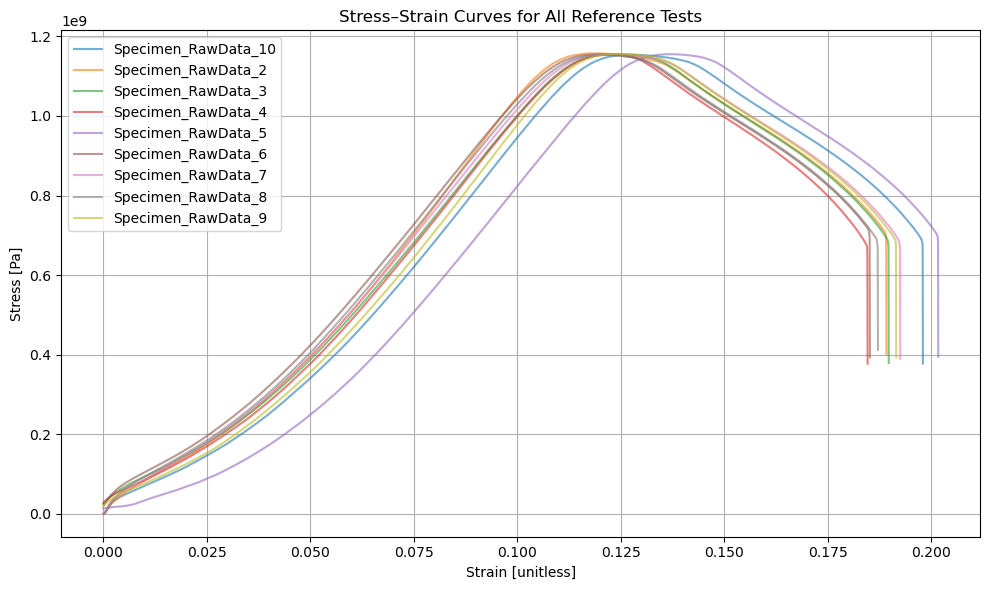

In [38]:
import matplotlib.pyplot as plt

## Grab the stress strain values from each of the CSVs

csv_files = glob.glob(os.path.join("./Reference Tests/Reference_T1/", "*.csv"))

stresses = np.zeros((len(csv_files), 800))
strains = np.zeros((len(csv_files), 800))
IDs = np.array([])

for i in range(len(csv_files)):
    print(csv_files[i][31:-4])
    E, stress, strain, disp, force = compute_youngs_modulus(csv_files[i], 1.25*25.4, (0.125*0.0254)*(0.25*0.0254))
    stresses[i][:len(stress)] = stress
    strains[i][:len(strain)] = strain
    IDs = np.append(IDs, csv_files[i][31:-4])


plt.figure(figsize=(10,6))

for i in range(stresses.shape[0]):
    # Mask out padded zeros if needed
    valid = strains[i] > 0
    plt.plot(strains[i][valid], stresses[i][valid], alpha=0.6, label=IDs[i])

plt.xlabel("Strain [unitless]")
plt.ylabel("Stress [Pa]")
plt.title("Stress–Strain Curves for All Reference Tests")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Gyroid 4

Data_1
Data_2
Data_3
Data_4


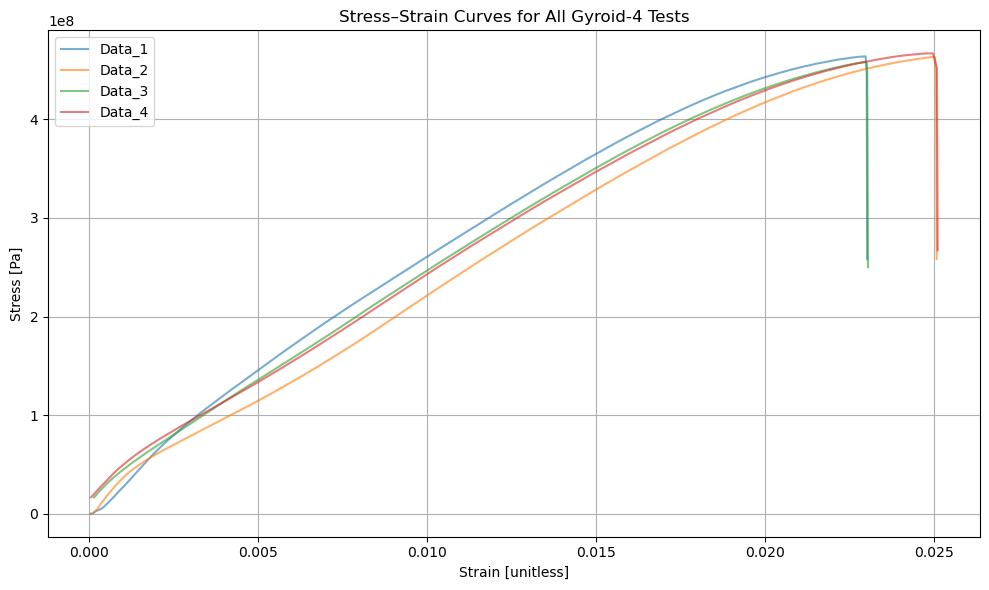

In [39]:
import matplotlib.pyplot as plt

## Grab the stress strain values from each of the CSVs

csv_files = glob.glob(os.path.join("./3DPrint/Gyroid_4/", "*.csv"))

length, cross_section_area, mean = combo_to_measurement["Gyroid_4"]

stresses = np.zeros((len(csv_files), 800))
strains = np.zeros((len(csv_files), 800))
IDs = np.array([])

for i in range(len(csv_files)):
    print(csv_files[i][31:-4])
    E, stress, strain, disp, force  = compute_youngs_modulus(csv_files[i], length, cross_section_area)
    stresses[i][:len(stress)] = stress
    strains[i][:len(strain)] = strain
    IDs = np.append(IDs, csv_files[i][31:-4])


plt.figure(figsize=(10,6))

for i in range(stresses.shape[0]):
    # Mask out padded zeros if needed
    valid = strains[i] > 0
    plt.plot(strains[i][valid], stresses[i][valid], alpha=0.6, label=IDs[i])

plt.xlabel("Strain [unitless]")
plt.ylabel("Stress [Pa]")
plt.title("Stress–Strain Curves for All Gyroid-4 Tests")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Data_1
Data_2
Data_3
Data_4


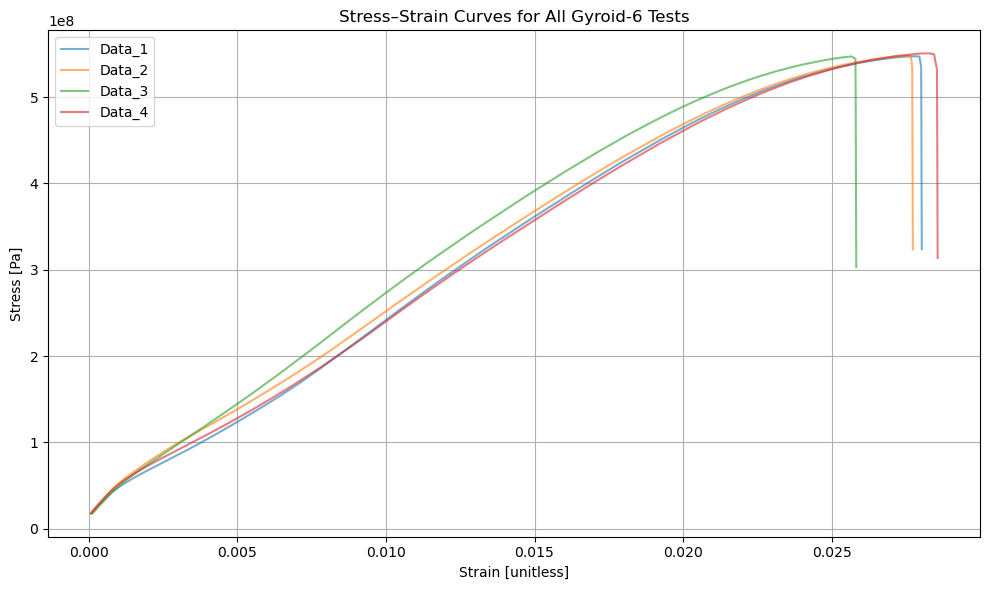

In [40]:
import matplotlib.pyplot as plt

## Grab the stress strain values from each of the CSVs

csv_files = glob.glob(os.path.join("./3DPrint/Gyroid_6/", "*.csv"))

length, cross_section_area, mean= combo_to_measurement["Gyroid_6"]

stresses = np.zeros((len(csv_files), 800))
strains = np.zeros((len(csv_files), 800))
IDs = np.array([])

for i in range(len(csv_files)):
    print(csv_files[i][31:-4])
    E, stress, strain, disp, force  = compute_youngs_modulus(csv_files[i], length, cross_section_area)
    stresses[i][:len(stress)] = stress
    strains[i][:len(strain)] = strain
    IDs = np.append(IDs, csv_files[i][31:-4])


plt.figure(figsize=(10,6))

for i in range(stresses.shape[0]):
    # Mask out padded zeros if needed
    valid = strains[i] > 0
    plt.plot(strains[i][valid], stresses[i][valid], alpha=0.6, label=IDs[i])

plt.xlabel("Strain [unitless]")
plt.ylabel("Stress [Pa]")
plt.title("Stress–Strain Curves for All Gyroid-6 Tests")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Gyroid 8


Data_1
Data_2
Data_3
Data_4


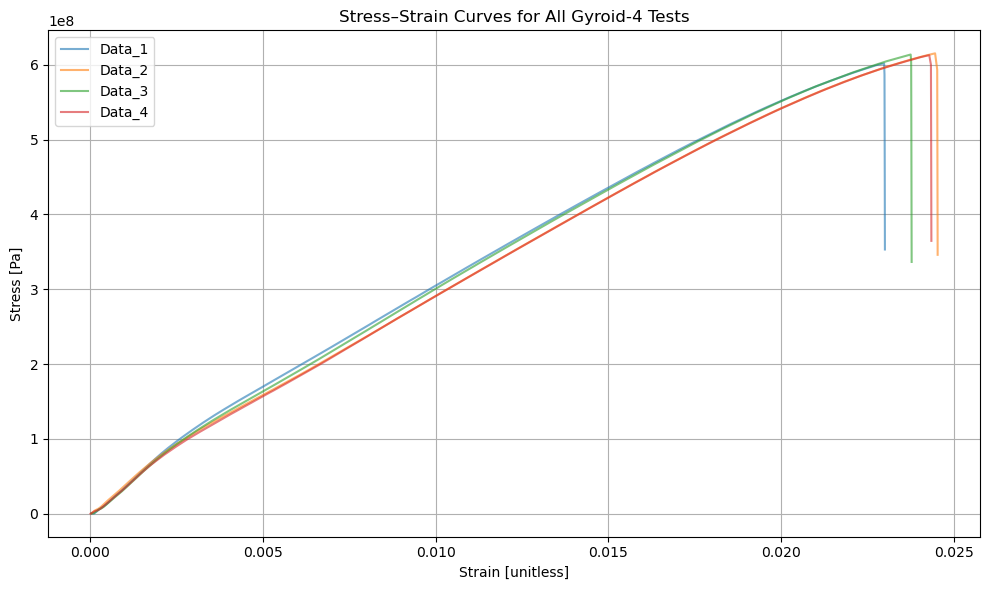

In [41]:
import matplotlib.pyplot as plt

## Grab the stress strain values from each of the CSVs

csv_files = glob.glob(os.path.join("./3DPrint/Gyroid_8/", "*.csv"))

length, cross_section_area, mean = combo_to_measurement["Gyroid_8"]

stresses = np.zeros((len(csv_files), 800))
strains = np.zeros((len(csv_files), 800))
IDs = np.array([])

for i in range(len(csv_files)):
    print(csv_files[i][31:-4])
    E, stress, strain, disp, force = compute_youngs_modulus(csv_files[i], length, cross_section_area)
    stresses[i][:len(stress)] = stress
    strains[i][:len(strain)] = strain
    IDs = np.append(IDs, csv_files[i][31:-4])


plt.figure(figsize=(10,6))

for i in range(stresses.shape[0]):
    # Mask out padded zeros if needed
    valid = strains[i] > 0
    plt.plot(strains[i][valid], stresses[i][valid], alpha=0.6, label=IDs[i])

plt.xlabel("Strain [unitless]")
plt.ylabel("Stress [Pa]")
plt.title("Stress–Strain Curves for All Gyroid-4 Tests")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Solid 4

Data_1
Data_2
Data_3
Data_4


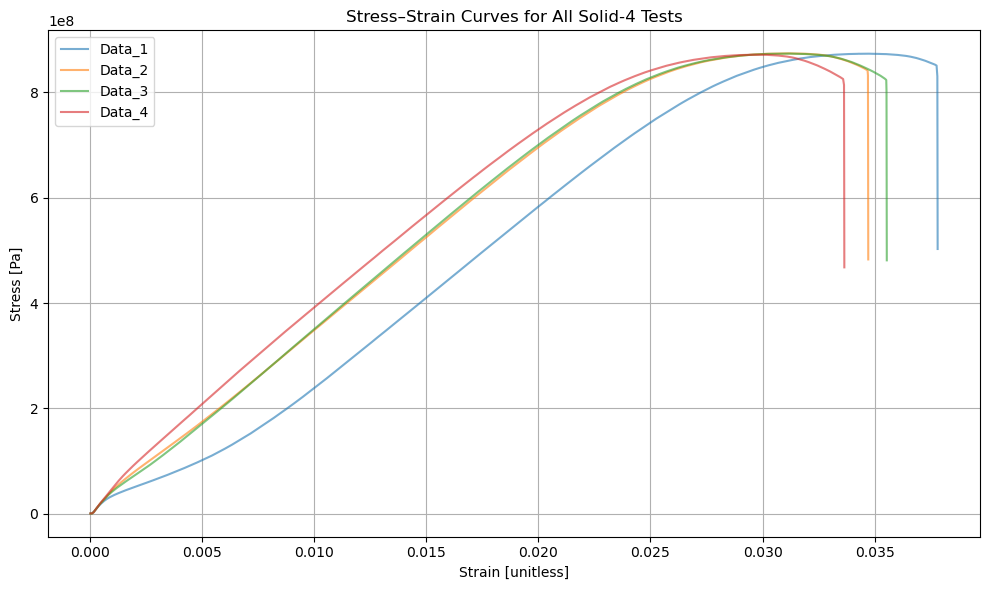

In [42]:
import matplotlib.pyplot as plt

## Grab the stress strain values from each of the CSVs

csv_files = glob.glob(os.path.join("./3DPrint/Solid_4/", "*.csv"))

length, cross_section_area, mean = combo_to_measurement["Solid_4"]

stresses = np.zeros((len(csv_files), 800))
strains = np.zeros((len(csv_files), 800))
IDs = np.array([])

for i in range(len(csv_files)):
    print(csv_files[i][30:-4])
    E, stress, strain, disp, force = compute_youngs_modulus(csv_files[i], length, cross_section_area)
    stresses[i][:len(stress)] = stress
    strains[i][:len(strain)] = strain
    IDs = np.append(IDs, csv_files[i][30:-4])


plt.figure(figsize=(10,6))

for i in range(stresses.shape[0]):
    # Mask out padded zeros if needed
    valid = strains[i] > 0
    plt.plot(strains[i][valid], stresses[i][valid], alpha=0.6, label=IDs[i])

plt.xlabel("Strain [unitless]")
plt.ylabel("Stress [Pa]")
plt.title("Stress–Strain Curves for All Solid-4 Tests")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Solid-6

Data_1
Data_2
Data_3
Data_4


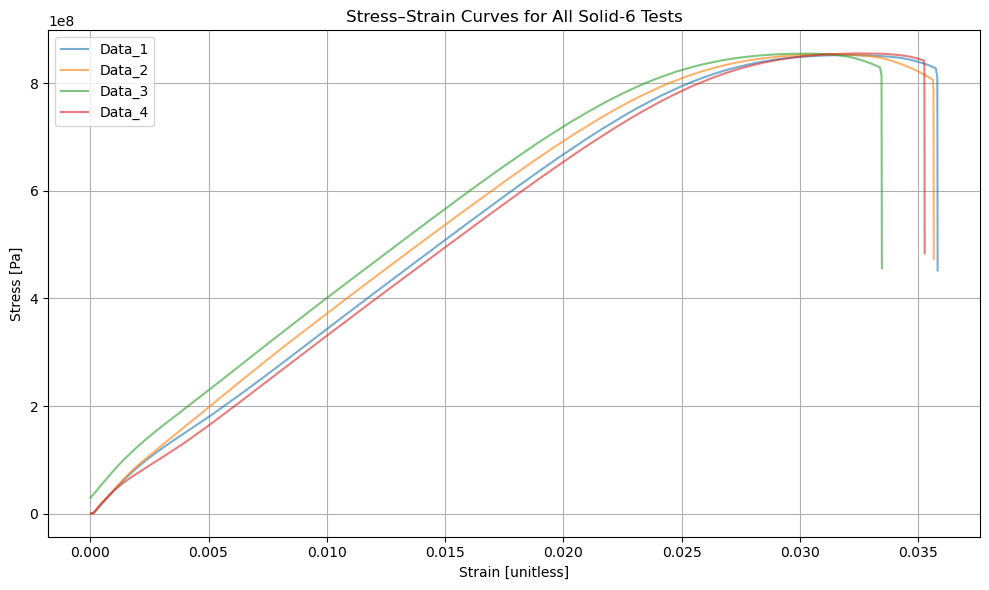

In [43]:
import matplotlib.pyplot as plt

## Grab the stress strain values from each of the CSVs

csv_files = glob.glob(os.path.join("./3DPrint/Solid_6/", "*.csv"))

length, cross_section_area, mean = combo_to_measurement["Solid_6"]

stresses = np.zeros((len(csv_files), 800))
strains = np.zeros((len(csv_files), 800))
IDs = np.array([])

for i in range(len(csv_files)):
    print(csv_files[i][30:-4])
    E, stress, strain, disp, force = compute_youngs_modulus(csv_files[i], length, cross_section_area)
    stresses[i][:len(stress)] = stress
    strains[i][:len(strain)] = strain
    IDs = np.append(IDs, csv_files[i][30:-4])


plt.figure(figsize=(10,6))

for i in range(stresses.shape[0]):
    # Mask out padded zeros if needed
    valid = strains[i] > 0
    plt.plot(strains[i][valid], stresses[i][valid], alpha=0.6, label=IDs[i])

plt.xlabel("Strain [unitless]")
plt.ylabel("Stress [Pa]")
plt.title("Stress–Strain Curves for All Solid-6 Tests")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Solid-8

Data_1
Data_2
Data_3
Data_4


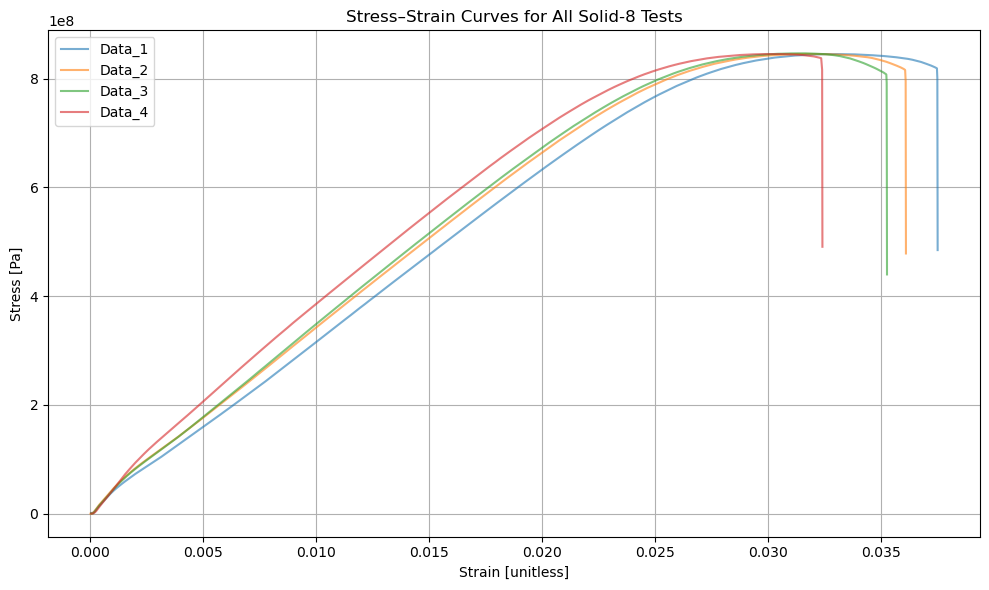

In [44]:
import matplotlib.pyplot as plt

## Grab the stress strain values from each of the CSVs

csv_files = glob.glob(os.path.join("./3DPrint/Solid_8/", "*.csv"))

length, cross_section_area, mean = combo_to_measurement["Solid_8"]

stresses = np.zeros((len(csv_files), 800))
strains = np.zeros((len(csv_files), 800))
IDs = np.array([])

for i in range(len(csv_files)):
    print(csv_files[i][30:-4])
    E, stress, strain, disp, force = compute_youngs_modulus(csv_files[i], length, cross_section_area)
    stresses[i][:len(stress)] = stress
    strains[i][:len(strain)] = strain
    IDs = np.append(IDs, csv_files[i][30:-4])


plt.figure(figsize=(10,6))

for i in range(stresses.shape[0]):
    # Mask out padded zeros if needed
    valid = strains[i] > 0
    plt.plot(strains[i][valid], stresses[i][valid], alpha=0.6, label=IDs[i])

plt.xlabel("Strain [unitless]")
plt.ylabel("Stress [Pa]")
plt.title("Stress–Strain Curves for All Solid-8 Tests")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Triangular 4

RawData_1
RawData_2
RawData_3
RawData_4


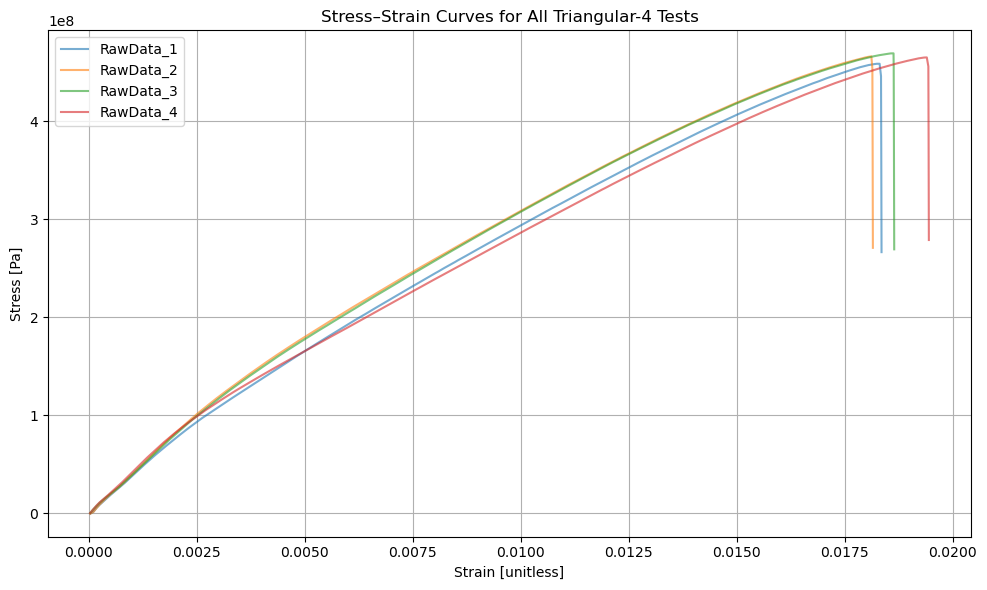

In [45]:
import matplotlib.pyplot as plt

## Grab the stress strain values from each of the CSVs

csv_files = glob.glob(os.path.join("./3DPrint/Triangular_4/", "*.csv"))

length, cross_section_area, mean = combo_to_measurement["Triangular_4"]

stresses = np.zeros((len(csv_files), 800))
strains = np.zeros((len(csv_files), 800))
IDs = np.array([])

for i in range(len(csv_files)):
    print(csv_files[i][32:-4])
    E, stress, strain, disp, force = compute_youngs_modulus(csv_files[i], length, cross_section_area)
    stresses[i][:len(stress)] = stress
    strains[i][:len(strain)] = strain
    IDs = np.append(IDs, csv_files[i][32:-4])


plt.figure(figsize=(10,6))

for i in range(stresses.shape[0]):
    # Mask out padded zeros if needed
    valid = strains[i] > 0
    plt.plot(strains[i][valid], stresses[i][valid], alpha=0.6, label=IDs[i])

plt.xlabel("Strain [unitless]")
plt.ylabel("Stress [Pa]")
plt.title("Stress–Strain Curves for All Triangular-4 Tests")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


RawData_1
RawData_2
RawData_3
RawData_4


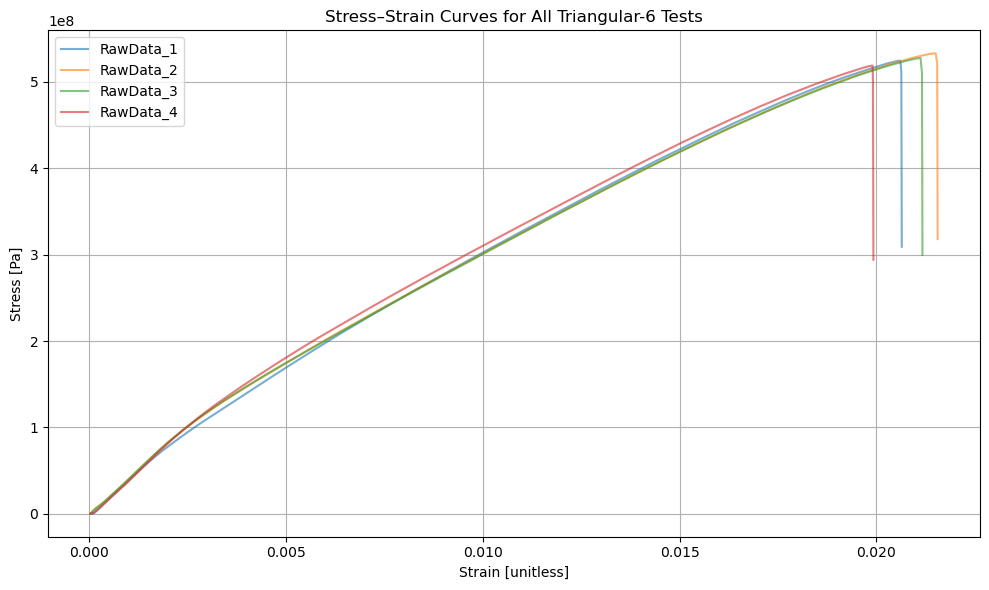

In [46]:
import matplotlib.pyplot as plt

## Grab the stress strain values from each of the CSVs

csv_files = glob.glob(os.path.join("./3DPrint/Triangular_6/", "*.csv"))

length, cross_section_area, mean = combo_to_measurement["Triangular_6"]

stresses = np.zeros((len(csv_files), 800))
strains = np.zeros((len(csv_files), 800))
IDs = np.array([])

for i in range(len(csv_files)):
    print(csv_files[i][32:-4])
    E, stress, strain, disp, force = compute_youngs_modulus(csv_files[i], length, cross_section_area)
    stresses[i][:len(stress)] = stress
    strains[i][:len(strain)] = strain
    IDs = np.append(IDs, csv_files[i][32:-4])


plt.figure(figsize=(10,6))

for i in range(stresses.shape[0]):
    # Mask out padded zeros if needed
    valid = strains[i] > 0
    plt.plot(strains[i][valid], stresses[i][valid], alpha=0.6, label=IDs[i])

plt.xlabel("Strain [unitless]")
plt.ylabel("Stress [Pa]")
plt.title("Stress–Strain Curves for All Triangular-6 Tests")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


RawData_1
RawData_2
RawData_3
RawData_4


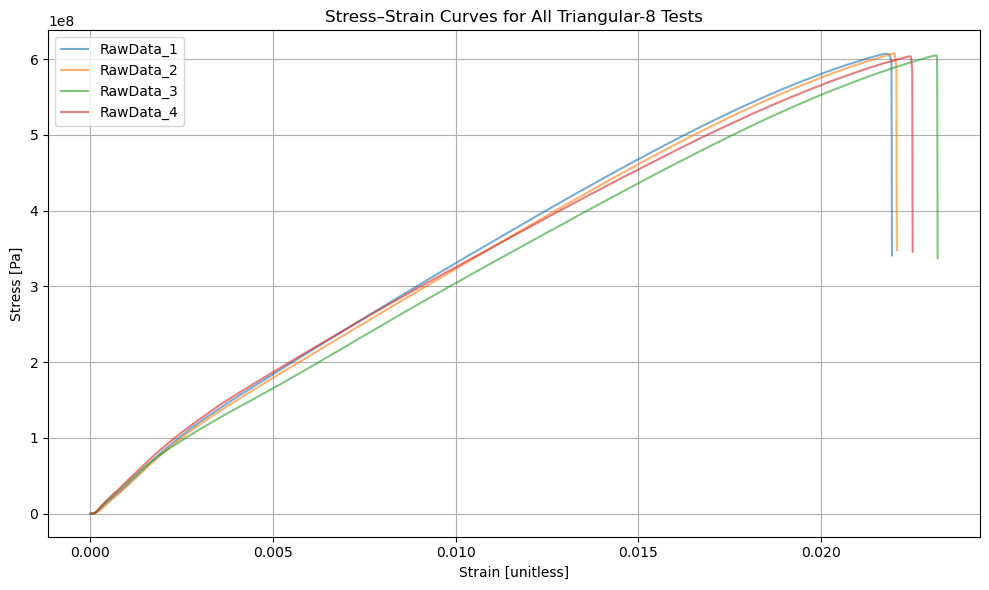

In [47]:
import matplotlib.pyplot as plt

## Grab the stress strain values from each of the CSVs

csv_files = glob.glob(os.path.join("./3DPrint/Triangular_8/", "*.csv"))

length, cross_section_area, mean = combo_to_measurement["Triangular_8"]

stresses = np.zeros((len(csv_files), 800))
strains = np.zeros((len(csv_files), 800))
IDs = np.array([])

for i in range(len(csv_files)):
    print(csv_files[i][32:-4])
    E, stress, strain, disp, force = compute_youngs_modulus(csv_files[i], length, cross_section_area)
    stresses[i][:len(stress)] = stress
    strains[i][:len(strain)] = strain
    IDs = np.append(IDs, csv_files[i][32:-4])


plt.figure(figsize=(10,6))

for i in range(stresses.shape[0]):
    # Mask out padded zeros if needed
    valid = strains[i] > 0
    plt.plot(strains[i][valid], stresses[i][valid], alpha=0.6, label=IDs[i])

plt.xlabel("Strain [unitless]")
plt.ylabel("Stress [Pa]")
plt.title("Stress–Strain Curves for All Triangular-8 Tests")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Aggregate Elongation vs Load

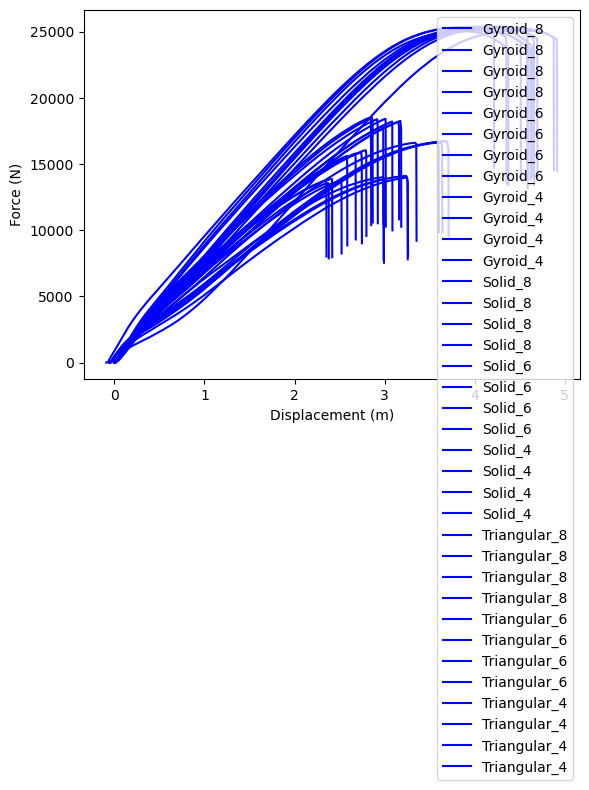

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']

for i in range(len(all_combinations)):
    length, cross_section_area, mean = combo_to_measurement[all_combinations[i]]
    csv_files = glob.glob(os.path.join("./3DPrint/"+all_combinations[i]+"/", "*.csv"))
    for csv_file in csv_files:
        E, stress, strain, disp, force = compute_youngs_modulus(csv_file, length, cross_section_area)
        plt.plot(disp, force, label=all_combinations[i], color=colors[i])

plt.xlabel("Displacement (m)")
plt.ylabel("Force (N)")
plt.legend()
plt.show()